# Trying to create a CIFAR 10 image prediction model

The CIFAR-10 data consists of 60,000 32x32 color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images in the official data.

In [63]:
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# includes
import torch
print(torch.cuda.is_available())
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

True


In [3]:
# saving and loading the model
def saveModel(model):
    torch.save(model.state_dict(), "CIFAR10Save.pth")

def loadModel(model):
    model.load_state_dict(torch.load("CIFAR10Save.pth"))

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=True)

In [5]:
# model class
class C10ImageClassifier(nn.Module):
    def __init__(self):
        super(C10ImageClassifier, self).__init__()
        
        # 2 conv layers with 32 depth on output (+ pooling + dropout)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # conv layer with 3 channels, 32 filters, 3x3 and we do 1 pixel 0 padding around
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        
        # 2 conv layers with 64 depth on output (+ pooling + dropout)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)
        
        # 2 conv layers with 128 depth on output (+ pooling + dropout)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.3)
        
        # fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 4x4 after 3 pooling layers
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)  # 10 output classes for cifar10
        
    def forward(self, x):
        # conv => batch norm => relu => conv => batch => relu => pooling => dropout
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # flatten the images to prepare for the FC layers
        x = x.view(-1, 128 * 4 * 4)
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

In [6]:
# model, optimizer and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda" if torch.cuda.is_available() else "cpu")

cifar10Model = C10ImageClassifier().to(device)
optimizer = optim.Adam(cifar10Model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cuda


In [ ]:
# don't run this as it'll clear the losses and accuracies logged during training
train_losses = []
train_accuracies = []

In [11]:
# training the model
def trainModel(nrEpochs):
    for epoch in range(nrEpochs):
        cifar10Model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        # looping through the trainloader
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = cifar10Model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Compute accuracy (for plotting)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = correct_predictions / total_predictions
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f"Epoch [{epoch + 1}/{nrEpochs}], Loss: {epoch_loss}")

In [14]:
# plotting loss and accuracy
def plotLossAndAccuracy():
    plt.figure(figsize=(12, 5))
    
    # loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [47]:
trainModel(10)

Epoch [1/10], Loss: 0.3381977393552661
Epoch [2/10], Loss: 0.3340240574553609
Epoch [3/10], Loss: 0.32283095276355744
Epoch [4/10], Loss: 0.31718697740882634
Epoch [5/10], Loss: 0.31076159197837117
Epoch [6/10], Loss: 0.3019257800988853
Epoch [7/10], Loss: 0.29940206826850774
Epoch [8/10], Loss: 0.2830238238833845
Epoch [9/10], Loss: 0.28465759589523076
Epoch [10/10], Loss: 0.2847730503864586


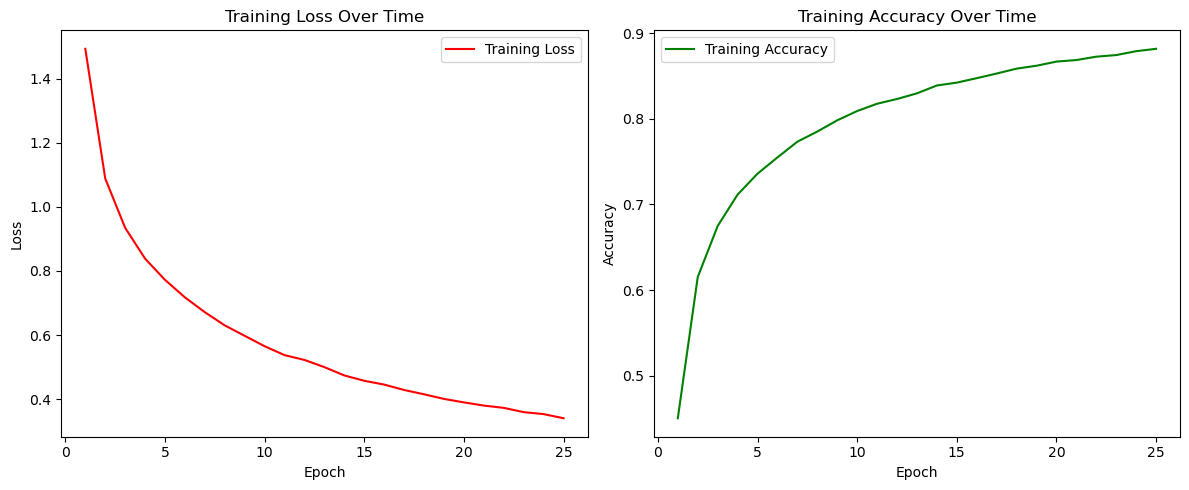

In [13]:
plotLossAndAccuracy() # the plot shown below is of the first 25 epochs

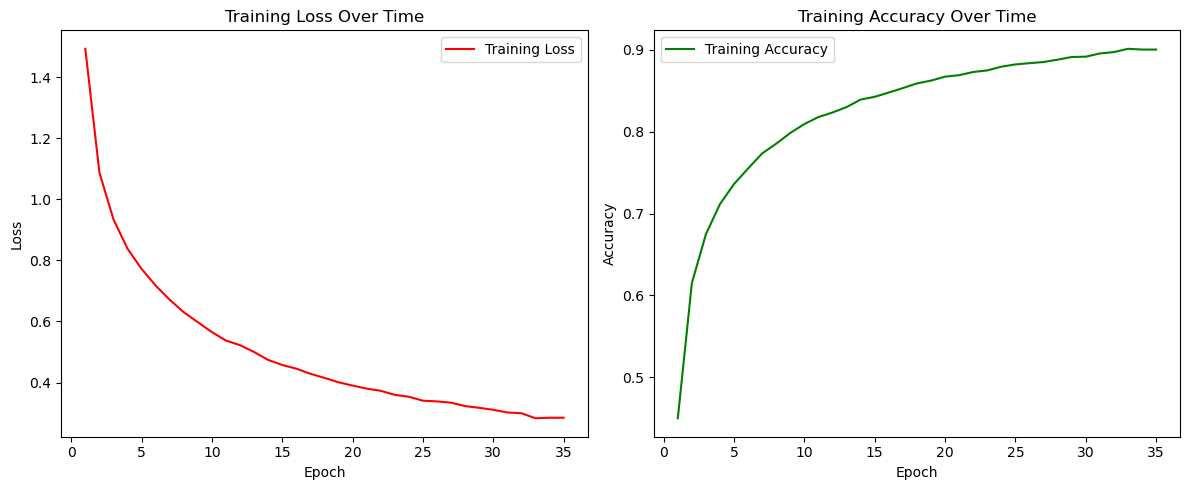

In [48]:
plotLossAndAccuracy() # the plot shown below is of all 35 of the epochs

In [30]:
nrToLabel = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [44]:
def testingSetAccuracy():
    cifar10Model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation to save memory and computation during evaluation
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU if available
            
            # Get model predictions
            outputs = cifar10Model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the predicted labels
            
            # Update the number of correct predictions and total predictions
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    
    # Calculate accuracy
    accuracy = 100 * correct_predictions / total_predictions
    return accuracy

In [49]:
print(f"Accuracy: {testingSetAccuracy()}%")

Accuracy: 86.87%


In [37]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor format to NumPy for displaying

def predictAndPlot(nrImages=5):
    cifar10Model.eval()  # set model to evaluation mode
    images, labels = next(iter(testloader))  # get a batch of test images
    images, labels = images[:nrImages], labels[:nrImages]  # limit to the first nrImages
    images, labels = images.to(device), labels.to(device)  # move data to the GPU if available

    # predict
    outputs = cifar10Model(images)
    _, predicted = torch.max(outputs, 1)  # get the predicted labels

    # plot the images with their predictions
    plt.figure(figsize=(12, 8))
    
    for i in range(nrImages):
        plt.subplot(1, nrImages, i + 1)
        imshow(images[i].cpu())  # move the image back to CPU for plotting
        plt.title(f"Predicted: {nrToLabel[predicted[i].item()]}\nLabel: {nrToLabel[labels[i].item()]}")
        plt.axis('off')
    
    plt.show()

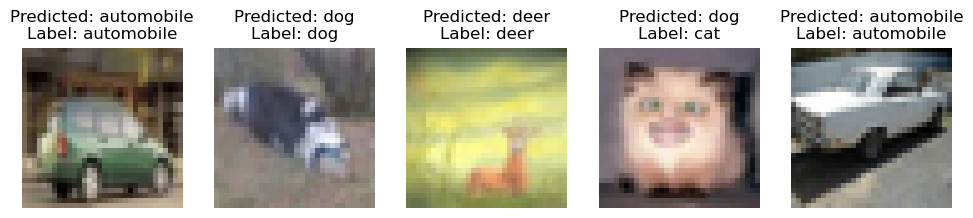

In [61]:
predictAndPlot(5)